# 상관계수로 데이터 분석

- Kaggle에 있는 Titanic 자료를 사용해서 배우는 상관계수
- 참고: https://www.kaggle.com/c/titanic/data

## IMPORT

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

train = pd.read_csv("../data/titanic/train.csv")
train.shape

(891, 12)

## 데이터 확인

PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked가 있어야 된다.
    - PassengerId: 승객 고유번호
    - Survived: 생존 유무
    - Pclass: Passenger Class, 선박이 각 class별로 구역이 나눠짐
    - Name: 이름
    - Age: 나이
    - SibSp: Sibling/Spouse, 형제자매, 부인
    - Parch: Parent/Child, 부모, 자식
    - Ticket: 티켓번호
    - Fare: 구매비용
    - Cabin: 캐빈 번호
    - Embarked: 승선지

In [2]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 데이터 처리

Titanic 데이터로 예측하고자 하는 것은 Survived, 즉, 생존이다.

이 말은즉슨, 상관계수로 생존에 가장 영향을 끼치는 요소가 뭔지 알아내야 된다.

In [3]:
# 일단 승객고유번호, 티켓번호, 이름, 승선지는 확인하지 않아도 생각이 되니 제거..
train.drop('PassengerId', axis=1, inplace=True)
train.drop('Ticket', axis=1, inplace=True)
train.drop('Name', axis=1, inplace=True)
train.drop('Embarked', axis=1, inplace=True)

In [4]:
# SibSp, Parch 처리
SibSp_nan = train["SibSp"] == 0
SibSp_is = train["SibSp"] > 0
train.loc[SibSp_nan,"SibSp"] = 0
train.loc[SibSp_is,"SibSp"] = 1

Parch_nan = train["Parch"] == 0
Parch_is = train["Parch"] > 0
train.loc[Parch_nan,"Parch"] = 0
train.loc[Parch_is,"Parch"] = 1

In [5]:
# Fare 처리
# Fare 같은 경우 최소값, 최대값의 차이가 크고,
# 정확한 분포도를 보기위해선 구분화해야 된다.
_101 = train["Fare"] > 100
train.loc[_101,"Fare"] = 500

_51_100 = (train["Fare"] > 50) & (train["Fare"] < 101)
train.loc[_51_100,"Fare"] = 100

_0_50 = (train["Fare"] > -0.1) & (train["Fare"] < 51)
train.loc[_0_50,"Fare"] = 50

Fare_dummies = pd.get_dummies(train['Fare'], prefix="Fare")
train = train.join(Fare_dummies)
train.drop('Fare', axis=1, inplace=True)

In [6]:
# Age 처리
# 나이를 구분화해야 분석하기가 쉬워진다.
# Age slicing
display(train["Age"].max(),
train["Age"].min(),
train["Age"].mean())
# max 80, min 0.42, mean 29.70~

kid = train["Age"] < 13
youth = (train["Age"] > 12) & (train["Age"] < 22)
adult = (train["Age"] > 21) & (train["Age"] < 51)
old = train["Age"] > 50

train.loc[kid, "Age"] = 12
train.loc[youth, "Age"] = 21
train.loc[adult, "Age"] = 50
train.loc[old, "Age"] = 80

Age_dummies = pd.get_dummies(train["Age"], prefix="Age")
train = train.join(Age_dummies)
train.drop("Age", axis=1, inplace=True)

80.0

0.42

29.69911764705882

In [7]:
# Cabin 처리
# 캐빈 같은경우 캐빈번호보단 있냐 없냐 구분하는게 낳은 편이다..
# WARNING: 2번 반복하지 말기~~~
cab_nan = train["Cabin"].isnull()
cab_is = train["Cabin"].notnull()

# Cabin이 있냐 없냐?
train.loc[cab_nan,"Cabin"] = 0
train.loc[cab_is,"Cabin"] = 1

In [8]:
# 성별 one-hot encoding 해준다
Sex_dummies = pd.get_dummies(train['Sex'], prefix="Sex")
train = train.join(Sex_dummies)
train.drop('Sex', axis=1, inplace=True)

In [9]:
# Passenger Class도 one-hot encoding 처리
Pclass_dummies = pd.get_dummies(train['Pclass'], prefix="Pclass")
train = train.join(Pclass_dummies)
train.drop('Pclass', axis=1, inplace=True)

## 생존률과의 상관계수

보다시피 여성이 제일 생존률이 높다. Pclass, Fare, Parch, SibSp, Age도 어느정도 생존에 영향을 준다.

돈 없는 남성은 거의 무조건 죽는다고 볼수 있을듯...?

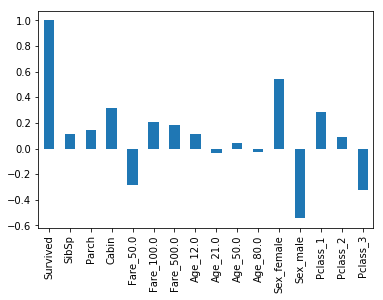

In [10]:
correlation = train.corr()
correlation.loc["Survived"].plot(kind="bar")
plt.show()

In [11]:
display(train.corr().loc["Survived"])

Survived      1.000000
SibSp         0.115867
Parch         0.147408
Cabin         0.316912
Fare_50.0    -0.286113
Fare_100.0    0.205384
Fare_500.0    0.182033
Age_12.0      0.116691
Age_21.0     -0.031012
Age_50.0      0.045270
Age_80.0     -0.022932
Sex_female    0.543351
Sex_male     -0.543351
Pclass_1      0.285904
Pclass_2      0.093349
Pclass_3     -0.322308
Name: Survived, dtype: float64

## Seaborn 패키지 사용해서 상관계수 보기

위처럼 Bar 그래프로 확인하거나 숫자로 직접확인 할 수 있지만

Seaborn을 사용하여 좀 더 쉽게, 확 와닸게 확인해볼 수 있다.

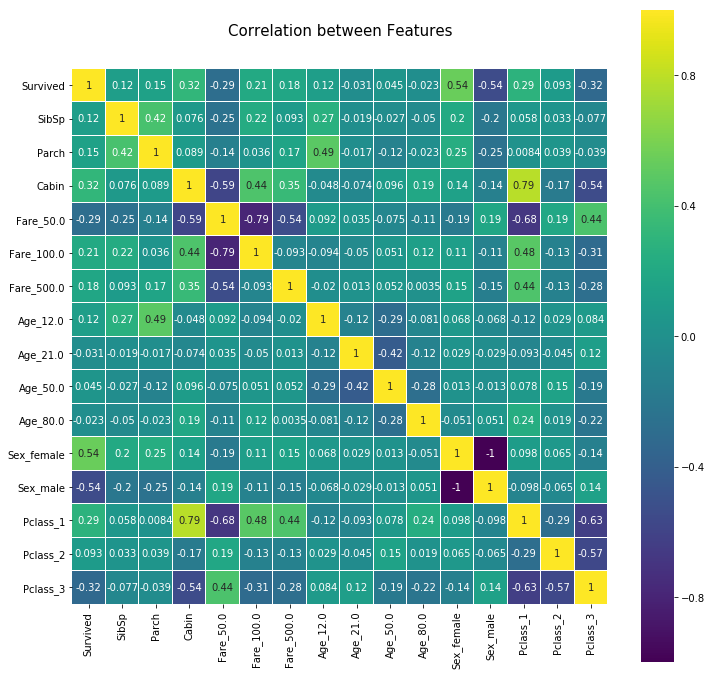

In [12]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Correlation between Features', y=1.05, size = 15)
sns.heatmap(train.corr(),
            linewidths=0.1, 
            vmax=1.0, 
            square=True, 
            cmap=colormap, 
            linecolor='white', 
            annot=True)

## 분석 결과
상관계수 높은 순서:
1. 여자
2. Cabin
3. Pclass_1
4. Fare_100
5. Fare_500
6. Parch
7. age_12
8. SibSp
9. age_50
...

남성, Pclass_3, Fare_50은 죽을 확률이 높다.
어떻게 보면 상관계수가 높은편이라 볼수 있긴 하다.
그러나, 남성은 어차피 여성의 반대라서 사용할 필요가 없다.

간단 생각:
1. 일단 성별은 무조건 중요하다.
2. Cabin 있냐 없냐의 여부도 중요하지만, cabin없는 사람이 너무 많다.
3. Pclass는 중요한데, 일단 Pclass_1는 생존률이 높고, 3은 낮고, 2는 애매하다.
4. Fare는 50 (0~50),100 (50~100),500 (100~500)으로 나눴는데...
    - 돈은 많이 낼수록 생존률이 높긴 높다.
    - 사람 비율로 따지자면 0~50에 있는 (저층 클래스) 사람들이 너무 많다.
    - 0~50낸 사람들은 죽는 확률이 높다. 0~50과 50~100의 차이가 너무 크다.
    - Fare는 확실히 분류를 다시 정의해 볼 필요가 있다.
5. Age는 생각보다 상관계수가 높지 않다. 오히려 범주형으로 나누니 너무 낮아진다.
6. Parch, SibSp는 상관계수가 애매하다. 